In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from importlib import reload

import warnings
warnings.simplefilter('ignore')

Необязательная фигня (нужна, если надо менять код в импортируемых модулях в процессе работы над ноутбуком).

In [2]:
%load_ext autoreload
%autoreload 2

### 1. Парсер.

Пример использования: нужна 101 форма, сохраняем архивы в заданной директории в папке 101_zipped, сами файлы сохраняются в заданной директории в папке 101. 

**Важные моменты**.
1. Поскольку эти файлы весят несколько гигабайт, я бы не рискнул загружать их в ту же папку, где хранится код для Github. Иначе, когда вы захотите закинуть свой код на гитхаб, вам придется ждать кучу времени, пока данные (больше 10 гб) передадутся.
2. Если какие-то файлы раньше были в папках, которые мы хотим стереть и которые вместе с данными создаем заново, все эти файлы надо закрыть до запуска скрипта! По умолчанию, если в папке, куда мы распаковываем данные, были подпапки с теми же названиями, что и названия папок, которые мы получим при распаковке - старые одноименные папки стираются. 
3. Сами формы 101 и 102 суммарно весят около **10 гб**. С учетом того, что они будут распакованы в два .csv файла, для скачивания и обработки форм нужно иметь не менее **15 гб** свободного места на диске.
4. **Путь**, по которому хранится файл, **должен состоять только из английских букв и слов**. Иначе некоторые Питоновские встроенные программы не работают, поскольку они не работают с кириллицей.

In [3]:
from preprocessing import load_bank_statements, get_bank_names

#### 1.1 Введем путь, по которому мы будем сохранять данные.

In [2]:
path = Path(str(input()))
print(f'Путь, по которому мы будем сохранять архивы и файлы dbf: {path}')

 C://Users//Ivand//Repos//banks//data


Путь, по которому мы будем сохранять архивы и файлы dbf: C:\Users\Ivand\Repos\banks\data


#### 1.2. Загрузим 101 и 102 формы.

In [5]:
%%time
load_bank_statements(form_number=101, filepath=path)

100%|██████████| 213/213 [00:00<00:00, 49001.03it/s]


Congratulations! Finished.
CPU times: user 114 ms, sys: 204 ms, total: 318 ms
Wall time: 2min


In [6]:
load_bank_statements(form_number=102, filepath=path)

100%|██████████| 72/72 [00:00<00:00, 26824.47it/s]


Congratulations! Finished.


#### 1.3. Считаем и объединим все файлы с именами.

Сделаем это для 101 и 102 формы, результат сравним. По идее, REGN - уникальные числовые индикаторы для названий банков - должны совпадать для всех форм (101, 102 и так далее) - еще один вопрос к Помориной.

Я записал путь для чтения названий банков из папки ``path/'101'``, так как такую запись позволяет библиотека Pathlib. Она есть в Питоне по умолчанию и очень удобна для работы с путями до файлов или папок.

In [9]:
out = get_bank_names(filepath=path/'101', form_number=101)

In [7]:
out.head(5)

,REGN,NAME_B
0,1,ЗАО ЮНИКРЕДИТ БАНК
1,3,"МАКБ ""ПРЕМЬЕР"" ЗАО"
2,21,"ООО ""ПРИМТЕРКОМБАНК"""
3,52,"ОАО ""ЭНЕРГОМАШБАНК"""
4,55,"ОАО МАБ ""ТЕМПБАНК"""


In [10]:
out102 = get_bank_names(filepath=path/'102', form_number=102)

In [9]:
out102.head(5)

,REGN,NAME_B
0,1,ЗАО ЮНИКРЕДИТ БАНК
1,3,"МАКБ ""ПРЕМЬЕР"" ЗАО"
2,21,"ООО ""ПРИМТЕРКОМБАНК"""
3,52,"ОАО ""ЭНЕРГОМАШБАНК"""
4,55,"ОАО МАБ ""ТЕМПБАНК"""


In [10]:
out.shape, out102.shape

((1143, 2), (1137, 2))

Не все банки, которые есть в форме 101, попали в форму 102. Возможно и обратное: если в 102 форме меньше банков, это не значит, что в ней нет названий, не попавших в форму 101. Посмотрим на банки, которые попали только в одну из двух форм:

In [11]:
mismatch = pd.concat([out, out102]).drop_duplicates(subset='REGN', keep=False)
mismatch
print(f'Количество банков, не попавших в обе формы: {mismatch.shape[0]}')

Количество банков, не попавших в обе формы: 6


Теперь уже за исследователем решение, что делать. Но поскольку этих банков не очень много, и они не слишком похожи на системно значимые, для модели дефолта оптимальная стратегия будет просто выкинуть их из выборки.

**Важно!** Также, чтобы не было путаницы с названиями, в дальнейшей работе надо будет использовать для работы и с формой 101, и с формой 102 один и тот же датафрейм с названиями банков - вполне возможно, название какого-то банка из формы 101 забито большими буквами в стобце `NAME_B` формы 102, может возникнуть ненужная путаница.

**Заметки по поводу агрегируемых файлов.**
1. Для сбора имен я считывал все файлы из 101 формы, в названии которых есть `N1`, для формы 102 ищутся файлы с `NP1` в названии. Но также для 2004-2008 в форме 101 есть файлы с `N`, в которых тоже содержатся имена банков - видимо, это для древнего формата отчетности. Аналогично, для формы 102 такие файлы содержат в названии `NP`. Вопрос: стоит ли учитывать более древние файлы? В связи с чем долгое время публиковались оба формата одновременно? Марина Александровна сказала разобраться с этим самостоятельно. Поскольку `N`, `NP1` в последние годы не публикуются, я решил использовать более современные файлы.
2. Аналогичный вопрос по самим отчетам - долгое время публиковалось сразу по 6 файлов за 1 месяц или квартал, то есть старый и новый форматы отчетности. В связи с чем это делалось? Стоит ли это учитывать, если да, то как? Я решил использовать более современные файлы с `B1` и `_P1` в названиях, которые публикуются с 2007 года по настоящее время.

#### 1.4. Считаем и объединим файлы с отчетностью.
Осталось считать сами файлы с отчетностью. Особенности считывания:
1. При считывании даты делаются индексом в табличке.
2. Есть ряд странных счетов в форме 101, расшифровку которых в документах ЦБ я найти не смог. Эти счета: ITGAP', '304.1', '408.1', '408.2', '474.1', '1XXXX', '2XXXX', '3XXXX', '4XXXX', '5XXXX', '6XXXX','7XXXX', '8XXXX', '9XXXX'. По умолчанию функция ``read_form`` удаляет эти счета. Это делается, чтобы столбец с номером счета можно было преобразовать в формат `integer`. Такое преобразование позволяет существенно оптимизировать скорость обработки файла и объем памяти, требуемой для хранения файла. За удаление ненужных параметров отвечает опция ``remove_unknown_accs.``
3. Опция ``to_int`` позволяет конвертировать столбец с номерами счетов в целочисленный формат.
4. До 2015 года в 102 форме не ставили столбец с датой. Это учтено, создается дата по названию папки.

In [4]:
from preprocessing import read_form

In [13]:
%%time
form_101 = read_form(path/'101', form_number=101)

Reading .dbf files from your PC, please wait...


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [01:49<00:00,  1.63it/s]


Opened files. Merging them...
Done.
Wall time: 7min 42s


In [14]:
form_101

,REGN,PLAN,NUM_SC,A_P,VR,VV,VITG,ORA,OVA,OITGA,ORP,OVP,OITGP,IR,IV,IITG,PRIZ
DT,,,,,,,,,,,,,,,,,
2007-01-01,1,А,10206,2,4540424.0,0.0,4540424.0,720888.0,0.0,720888.0,3107579.0,0.0,3107579.0,6927115.0,0.0,6927115.0,1
2007-01-01,2721,А,47411,2,6339.0,5913.0,12252.0,2935.0,726.0,3661.0,2329.0,2328.0,4657.0,5733.0,7515.0,13248.0,1
2007-01-01,2721,А,47408,1,0.0,0.0,0.0,11788.0,51990.0,63778.0,11788.0,51990.0,63778.0,0.0,0.0,0.0,1
2007-01-01,2721,А,47407,2,0.0,0.0,0.0,45580.0,18218.0,63798.0,45580.0,18218.0,63798.0,0.0,0.0,0.0,1
2007-01-01,2721,А,47405,2,0.0,0.0,0.0,0.0,4859.0,4859.0,0.0,4859.0,4859.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,1557,А,70616,1,50479.0,0.0,50479.0,0.0,0.0,0.0,0.0,0.0,0.0,50479.0,0.0,50479.0,1
2021-10-01,1557,А,70614,1,0.0,0.0,0.0,558549.0,0.0,558549.0,558549.0,0.0,558549.0,0.0,0.0,0.0,1
2021-10-01,1557,А,70608,1,18335051.0,0.0,18335051.0,1693182.0,0.0,1693182.0,0.0,0.0,0.0,20028233.0,0.0,20028233.0,1


Посмотрим на столбцы и типы данных в объединенной 101 форме.

In [15]:
form_101.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22407382 entries, 2007-01-01 to 2021-10-01
Data columns (total 17 columns):
 #   Column  Dtype  
---  ------  -----  
 0   REGN    int64  
 1   PLAN    object 
 2   NUM_SC  int32  
 3   A_P     object 
 4   VR      float64
 5   VV      float64
 6   VITG    float64
 7   ORA     float64
 8   OVA     float64
 9   OITGA   float64
 10  ORP     float64
 11  OVP     float64
 12  OITGP   float64
 13  IR      float64
 14  IV      float64
 15  IITG    float64
 16  PRIZ    int64  
dtypes: float64(12), int32(1), int64(2), object(2)
memory usage: 2.9+ GB


Теперь 102 форма.

In [16]:
%%time
form_102 = read_form(path/'102', 102)

Reading .dbf files from your PC, please wait...


100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 19857.83it/s]


Opened files. Merging them...
Done.
Wall time: 5min 23s


In [17]:
form_102

,REGN,CODE,SIM_R,SIM_V,SIM_ITOGO
DT,,,,,
2007-01-01,1,10000,81264287.0,10621859.0,91886146.0
2007-01-01,2838,21201,0.0,0.0,0.0
2007-01-01,2838,21104,0.0,0.0,0.0
2007-01-01,2838,21103,0.0,0.0,0.0
2007-01-01,2838,21102,14.0,0.0,14.0
...,...,...,...,...,...
2021-10-01,1927,37503,0.0,NaN,0.0
2021-10-01,1927,37504,0.0,NaN,0.0
2021-10-01,1927,37505,0.0,NaN,0.0


In [19]:
form_102.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29308947 entries, 2007-01-01 to 2021-10-01
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   REGN       int64  
 1   CODE       int32  
 2   SIM_R      float64
 3   SIM_V      float64
 4   SIM_ITOGO  float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.2 GB


#### 1.5 Сохраним объединенные таблицы с отчетностью.
Сохраним оба файла в папку с данными. Сохранять в ``csv`` бесполезно - это займет кучу времени. Надо сохранять в формате ``HDF``, он работает гораздо быстрее.

In [18]:
%%time
form_101.to_hdf(path/'101.h5', key='101', mode='w')
form_102.to_hdf(path/'102.h5', key='102', mode='w')

Wall time: 40.3 s


### 2. Группировка.
Теперь попробуем работать с группировкой. 
Для группировки посчитаем 
- розничные кредиты физическим лицам, включая просроченные, 
- и кредиты юридическим лица на балансе банков по [методике КУАП](https://kuap.ru/methodics/). 

При проверке будем учитывать, что 101 форма в тысячах рублей (**Проверить что со 102 насчет размерности**).

Загрузим функцию ``group``, которая отвечает за группировку. Есть два варианта, как передать ей схему для группировки: в виде словаря или в виде датафрейма.

Предлагаю, чтобы не портить код вставками гигантских словарей для группировки по счетам, сохранять
- словари для группировки в файле parameters.py, как это сделал я со словарем для примера - ``example_dict``
- или же, если информация для группировки счетов хранится в виде датафреймов, сохранять эти датафреймы в excel или csv в папке ``data``

**Вариант 1. Словарь для группировки**.

In [7]:
form_101 = pd.read_hdf(path/'101.h5',key='101')

In [8]:
from preprocessing import group
from parameters import example_dict

In [9]:
print(f"""
Первая пара "новый счет: список старых счетов" для группировочного словаря:
{list(example_dict.keys())[0]}:{list(example_dict.values())[0][0:3]}...
Вторая пара "новый счет: список старых счетов" для группировочного словаря:
{list(example_dict.keys())[1]}:{list(example_dict.values())[1][0:3]}...
""")


Первая пара "новый счет: список старых счетов" для группировочного словаря:
Кредиты физическим лицам:[45502, 45508, 45509]...
Вторая пара "новый счет: список старых счетов" для группировочного словаря:
Кредиты юридическим лицам:[45101, 45103, 45109]...



In [10]:
%%time
credits = group(data=form_101, aggschema=example_dict, form=101)

Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 9.07 s, sys: 3.08 s, total: 12.1 s
Wall time: 12.2 s


In [11]:
credits.head()

,REGN,new_code,IITG
DT,,,
2007-01-01,1,Кредиты физическим лицам,22332830.0
2007-01-01,1,Кредиты юридическим лицам,125305798.0
2007-02-01,1,Кредиты физическим лицам,23046669.0
2007-02-01,1,Кредиты юридическим лицам,126756486.0
2007-03-01,1,Кредиты физическим лицам,23806028.0


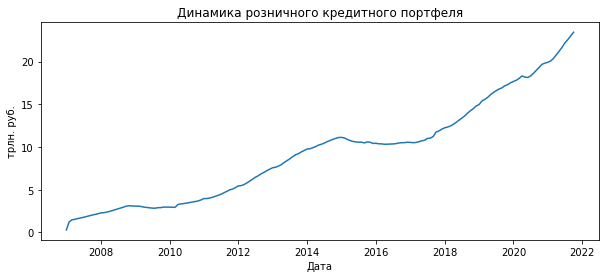

In [12]:
fiz = credits.groupby([credits.index, credits.new_code]).agg({'IITG':'sum'}).reset_index()
fiz = fiz[['DT', 'new_code', 'IITG']]
fiz.IITG = fiz.IITG/(10**9)
fiz = fiz[fiz['new_code']=='Кредиты физическим лицам']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(fiz.DT, fiz.IITG)
ax.set_title('Динамика розничного кредитного портфеля')
ax.set_xlabel('Дата')
ax.set_ylabel('трлн. руб.')
fig.show();

Что ж, здесь вполне четко видно три кредитных цикла в розничном кредитовании России. Заметим, что первое наблюдение явно похоже на выброс - в январе 2007 года банки только начали публиковать отчетность в новом формате, возможно, стоит просто выкинуть этот месяц из выборки.

Сравним с тем, что показывает ЦБ в агрегированной статистике банковского сектора за август. ЦБ показало кредиты физлицам на 23.08 трлн руб в августе, на 22.67 трлн. руб. в июле. А у нас?

In [13]:
fiz.iloc[-3:]

,DT,new_code,IITG
350,2021-08-01,Кредиты физическим лицам,22.583117
352,2021-09-01,Кредиты физическим лицам,23.025961
354,2021-10-01,Кредиты физическим лицам,23.445702


Наши расчеты стабильно меньше на 2.2%.

**Вариант 2. Датафрейм для группировки.**

Сделаем из нашего датафрейма словарь и пихнем его в функцию.

In [14]:
newdict = {y:x[0] for x in example_dict.items() for y in x[1]}
aggdf = pd.DataFrame({'new_code': list(newdict.values()),
                      'NUM_SC': list(newdict.keys())})
aggdf.head()

,new_code,NUM_SC
0,Кредиты физическим лицам,45502
1,Кредиты физическим лицам,45508
2,Кредиты физическим лицам,45509
3,Кредиты физическим лицам,45701
4,Кредиты физическим лицам,45707


In [15]:
%%time
credits_2 = group(data=form_101, aggschema=aggdf, form=101)

Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 8.83 s, sys: 2.85 s, total: 11.7 s
Wall time: 11.6 s


Проверим, что результаты совпадают.

In [30]:
from pandas._testing import assert_frame_equal
assert_frame_equal(credits, credits_2)

Все совпало. Это победа!

#### Получаем словари для группировки 

Импортируем функцию для группировки

In [97]:
from preprocessing import create_all_dictionaries_for_one_sheet

In [98]:
import sys

In [99]:
import preprocessing

In [100]:
from preprocessing import create_all_dictionaries_for_one_sheet

Укажем путь к файлу с деревьями

In [94]:
path = Path(str(input()))
print(f'Путь, по которому лежит файл Деревья.xlsx: {path}.')

 C://Users//Ivand//Repos//banks//data


Путь, по которому лежит файл Деревья.xlsx: C:\Users\Ivand\Repos\banks\data.


Выгрузим листы с группировками из этого файла

In [95]:
trees = [pd.read_excel(path / "Derevya.xlsx", sheet_name = i) \
         for i in range(6)]

trees_forms = ["BS"]*2+["PNL"]*3

Загрузим неагрегированные данные.

In [8]:
form_101 = pd.read_hdf(path/'101.h5',key='101')
form_102 = pd.read_hdf(path/'102.h5',key='102')

Получим список словарей для пятого уровня группировки PNL и второго BS (занимает меньше минуты).

In [101]:
#%%time
all_dicts = [create_all_dictionaries_for_one_sheet(tree, 5, 2, form) \
                    for tree, form in zip(trees, trees_forms)]

In [102]:
dict_names = ["BS_old", 
              "BS_new", 
              "PNL_very_old", 
              "PNL_old", 
              "PNL"]
dict_of_dicts = dict(zip(dict_names, all_dicts))

In [12]:
import json

In [26]:
with open('grouping_dict.json', 'w', encoding="utf-8") as f:
    json.dump(dict_of_dicts, f, indent=4, ensure_ascii=False)



In [ ]:
#load it

with open('grouping_dict.json', encoding="utf-8") as f:
    dict_of_dicts = json.load(f)

### Группировка

In [13]:
form_101 = pd.read_hdf(path/'101.h5',key='101')
form_102 = pd.read_hdf(path/'102.h5',key='102')

In [14]:
from preprocessing import group_one_form                          

In [15]:
import preprocessing

In [16]:
form_101.NUM_SC = form_101.NUM_SC.apply(str)

Насколько я понял Марину Александровну, с учетом измненения плана счетов листы в файле `Деревья.xlsx` соответствуют следующим датам включительно (привожу в том порядке, в каком выше эти листы загружались из экселя):
1. Первый лист - форма 101 - январь 2005 - июнь 2017.
2. Второй лист - форма 101 - июль 2017 - 2020 год.
3. Форма 102 - январь 2005 - март 2008.
4. Форма 102 - апрель 2008 (точнее, июнь, так как отчетность квартальная) - март 2016.
5. Форма 102 - апрель 2016 - 2020 год.

Исходя из этого, создадим подвыборки из исходного баланса и ОПУ.

In [17]:
bs_old = form_101['2005-01':'2017-06']
bs_new = form_101['2017-07':]

pnl_very_old = form_102['2005-01':'2008-03']
pnl_old = form_102['2008-04':'2016-03']
pnl_new = form_102['2016-04':]

Сделаем саму агрегацию.

In [32]:
aggregated_bs = pd.DataFrame([], columns = ["REGN", "new_code"])
aggregated_bs

,REGN,new_code


In [18]:
aggregated_bs = pd.DataFrame([], columns = ["REGN", "new_code", "IITG_positive", "IITG_negative", "IITG"])
for bs_aggregation_level in range(1, 4):
    dictionary_bs_old = create_all_dictionaries_for_one_sheet(trees[0], 100, bs_aggregation_level, "BS")
    dictionary_bs_new = create_all_dictionaries_for_one_sheet(trees[1], 100, bs_aggregation_level, "BS")
    dict_of_dicts ={"BS_old" : dictionary_bs_old,
                   "BS_new" : dictionary_bs_new}
    aggregated_table_old = group_one_form(bs_old, "BS_old", dict_of_dicts)
    aggregated_table_new = group_one_form(bs_new, "BS_new", dict_of_dicts)
    aggregated_table_level = aggregated_table_old.append(aggregated_table_new)
    aggregated_bs = aggregated_bs.append(aggregated_table_level)
aggregated_bs.index.name = "DT"

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


In [35]:
aggregated_bs

,REGN,new_code,IITG_positive,IITG_negative,IITG
2007-01-01,1,Активы,247540860.0,5705051.0,241835809.0
2007-01-01,1,Собственный капитал,1986575.0,22668538.0,-20681963.0
2007-02-01,1,Активы,260244124.0,5424592.0,254819532.0
2007-02-01,1,Собственный капитал,7629530.0,29282442.0,-21652912.0
2007-03-01,1,Активы,253872538.0,5581116.0,248291422.0
...,...,...,...,...,...
2021-10-01,3540,Обязательства по налогу на прибыль,0.0,28814.0,-28814.0
2021-10-01,3540,Прочие пассивы,0.0,117071.0,-117071.0
2021-10-01,3540,Средства банков,0.0,4446915.0,-4446915.0
2021-10-01,3540,Средства клиентов-резидентов,0.0,338.0,-338.0


In [19]:
aggregated_pnl = pd.DataFrame([], columns = ["REGN", "new_code", "SIM_ITOGO_positive", "SIM_ITOGO_negative", "IITG"])
for pnl_aggregation_level in range(1, 8):
    dictionary_pnl_very_old = create_all_dictionaries_for_one_sheet(trees[2], pnl_aggregation_level, 100, "PNL")
    dictionary_pnl_old = create_all_dictionaries_for_one_sheet(trees[3], pnl_aggregation_level, 100, "PNL")
    dictionary_pnl_new = create_all_dictionaries_for_one_sheet(trees[4], pnl_aggregation_level, 100, "PNL")
    dict_of_dicts ={"PNL_very_old" : dictionary_pnl_very_old,
                   "PNL_old" : dictionary_pnl_old,
                   "PNL" : dictionary_pnl_new}
    aggregated_table_very_old = group_one_form(pnl_very_old, "PNL_very_old", dict_of_dicts)
    aggregated_table_old = group_one_form(pnl_old, "PNL_old", dict_of_dicts)
    aggregated_table_new = group_one_form(pnl_new, "PNL", dict_of_dicts)
    aggregated_table_level = aggregated_table_very_old.append(aggregated_table_old)
    aggregated_table_level = aggregated_table_level.append(aggregated_table_new)

    aggregated_pnl = aggregated_pnl.append(aggregated_table_level)
aggregated_pnl.index.name = "DT"

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping

In [20]:
aggregated_pnl

,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2007-01-01,1,Чистая прибыль /(убыток),86446964.0,91886146.0,-5439182.0
2007-04-01,1,Чистая прибыль /(убыток),22420059.0,24903538.0,-2483479.0
2007-07-01,1,Чистая прибыль /(убыток),48271582.0,52564304.0,-4292722.0
2007-10-01,1,Чистая прибыль /(убыток),91089682.0,97016561.0,-5926879.0
2008-01-01,1,Чистая прибыль /(убыток),132136185.0,140650475.0,-8514290.0
...,...,...,...,...,...
2021-10-01,3540,Прочие доходы,0.0,29.0,-29.0
2021-10-01,3540,Реализованные доходы по операцям с драг.металл...,0.0,0.0,0.0
2021-10-01,3540,Реализованные доходы по операцям с иностранной...,0.0,0.0,0.0


In [102]:
aggregated_pnl_itogo = aggregated_pnl[["REGN", "new_code", "IITG"]]
aggregated_pnl_itogo = aggregated_pnl_itogo.pivot_table(index = ["DT", "REGN"], columns = ["new_code"], values = ["IITG"])
aggregated_pnl_itogo = aggregated_pnl_itogo.reset_index()
dropedlevel = aggregated_pnl_itogo.columns.droplevel(0)
dropedlevel = list(dropedlevel)
dropedlevel[0] = "DT"
dropedlevel[1] = "REGN"
aggregated_pnl_itogo.columns = dropedlevel
aggregated_pnl_itogo.to_excel(f"{path}//PNL_aggregated.xlsx")
aggregated_pnl_itogo.to_hdf(path/'PNL_aggregated.h5', key='102', mode='w')


In [103]:
aggregated_bs_itogo = aggregated_bs[["REGN", "new_code", "IITG"]]
aggregated_bs_itogo = aggregated_bs_itogo.pivot_table(index = ["DT", "REGN"], columns = ["new_code"], values = ["IITG"])
aggregated_bs_itogo = aggregated_bs_itogo.reset_index()
dropedlevel = aggregated_bs_itogo.columns.droplevel(0)
dropedlevel = list(dropedlevel)
dropedlevel[0] = "DT"
dropedlevel[1] = "REGN"
aggregated_bs_itogo.columns = dropedlevel
aggregated_bs_itogo.to_excel(f"{path}//BS_aggregated.xlsx")
aggregated_bs_itogo.to_hdf(path/'BS_aggregated.h5', key='102', mode='w')


In [ ]:
aggregated_pnl_itogo.to_excel(f"{path}//PNL_aggregated.xlsx")

In [68]:
aggregated_bs_itogo = aggregated_bs[["REGN", "new_code", "IITG"]]
aggregated_bs_itogo = aggregated_bs_itogo.pivot_table(index = ["DT", "REGN"], columns = ["new_code"], values = ["REGN", "IITG"])
aggregated_bs_itogo.to_excel(f"{path}//BS_aggregated.xlsx")

In [74]:
aggregated_bs_narrow = pd.DataFrame([], columns = ["REGN", "new_code", "IITG_positive", "IITG_negative", "IITG"])
for bs_aggregation_level in range(1, 3):
    dictionary_bs_old = create_all_dictionaries_for_one_sheet(trees[0], 100, bs_aggregation_level, "BS")
    dictionary_bs_new = create_all_dictionaries_for_one_sheet(trees[1], 100, bs_aggregation_level, "BS")
    dict_of_dicts ={"BS_old" : dictionary_bs_old,
                   "BS_new" : dictionary_bs_new}
    aggregated_table_old = group_one_form(bs_old, "BS_old", dict_of_dicts)
    aggregated_table_new = group_one_form(bs_new, "BS_new", dict_of_dicts)
    aggregated_table_level = aggregated_table_old.append(aggregated_table_new)
    aggregated_bs_narrow = aggregated_bs_narrow.append(aggregated_table_level)
aggregated_bs_narrow.index.name = "DT"

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


In [75]:
aggregated_bs_narrow

,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2007-01-01,1,Активы,247540860.0,5705051.0,241835809.0
2007-01-01,1,Собственный капитал,1986575.0,22668538.0,-20681963.0
2007-02-01,1,Активы,260244124.0,5424592.0,254819532.0
2007-02-01,1,Собственный капитал,7629530.0,29282442.0,-21652912.0
2007-03-01,1,Активы,253872538.0,5581116.0,248291422.0
...,...,...,...,...,...
2021-10-01,3540,Обязательства по налогу на прибыль,0.0,28814.0,-28814.0
2021-10-01,3540,Прочие пассивы,0.0,117071.0,-117071.0
2021-10-01,3540,Средства банков,0.0,4446915.0,-4446915.0


In [76]:
aggregated_pnl_narrow = pd.DataFrame([], columns = ["REGN", "new_code", "SIM_ITOGO_positive", "SIM_ITOGO_negative", "IITG"])
for pnl_aggregation_level in range(1,7):
    dictionary_pnl_very_old = create_all_dictionaries_for_one_sheet(trees[2], pnl_aggregation_level, 100, "PNL")
    dictionary_pnl_old = create_all_dictionaries_for_one_sheet(trees[3], pnl_aggregation_level, 100, "PNL")
    dictionary_pnl_new = create_all_dictionaries_for_one_sheet(trees[4], pnl_aggregation_level, 100, "PNL")
    dict_of_dicts ={"PNL_very_old" : dictionary_pnl_very_old,
                   "PNL_old" : dictionary_pnl_old,
                   "PNL" : dictionary_pnl_new}
    aggregated_table_very_old = group_one_form(pnl_very_old, "PNL_very_old", dict_of_dicts)
    aggregated_table_old = group_one_form(pnl_old, "PNL_old", dict_of_dicts)
    aggregated_table_new = group_one_form(pnl_new, "PNL", dict_of_dicts)
    aggregated_table_level = aggregated_table_very_old.append(aggregated_table_old)
    aggregated_table_level = aggregated_table_level.append(aggregated_table_new)

    aggregated_pnl_narrow = aggregated_pnl_narrow.append(aggregated_table_level)
aggregated_pnl_narrow.index.name = "DT"

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Grouping

In [77]:
aggregated_pnl_narrow

,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2007-01-01,1,Чистая прибыль /(убыток),86446964.0,91886146.0,-5439182.0
2007-04-01,1,Чистая прибыль /(убыток),22420059.0,24903538.0,-2483479.0
2007-07-01,1,Чистая прибыль /(убыток),48271582.0,52564304.0,-4292722.0
2007-10-01,1,Чистая прибыль /(убыток),91089682.0,97016561.0,-5926879.0
2008-01-01,1,Чистая прибыль /(убыток),132136185.0,140650475.0,-8514290.0
...,...,...,...,...,...
2021-07-01,3540,Прочие операционные доходы,0.0,84.0,-84.0
2021-07-01,3540,Чистые доходы по операциям прочей аренды,0.0,0.0,0.0
2021-10-01,3540,Доходы по услугам и комиссии полученные,0.0,28209.0,-28209.0


In [78]:
aggregated_pnl_narrow_itogo = aggregated_pnl_narrow[["REGN", "new_code", "IITG"]]
aggregated_pnl_narrow_itogo = aggregated_pnl_narrow_itogo.pivot_table(index = ["DT", "REGN"], columns = ["new_code"], values = ["REGN", "IITG"])
aggregated_pnl_narrow_itogo.to_excel(f"{path}//PNL_aggregated_narrow.xlsx")

In [79]:
aggregated_bs_narrow_itogo = aggregated_bs_narrow[["REGN", "new_code", "IITG"]]
aggregated_bs_narrow_itogo = aggregated_bs_narrow_itogo.pivot_table(index = ["DT", "REGN"], columns = ["new_code"], values = ["REGN", "IITG"])
aggregated_bs_narrow_itogo.to_excel(f"{path}//BS_aggregated_narrow.xlsx")

In [31]:
%%time
grouped_bs_old = group_one_form(bs_old, "BS_old", dict_of_dicts)
grouped_bs_old

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 22.3 s, sys: 5.64 s, total: 27.9 s
Wall time: 27.8 s


,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2007-01-01,1,Денежные средства (касса и остатки на кор.счет...,16692537.0,0.0,16692537.0
2007-01-01,1,Инвестиции,522840.0,1846.0,520994.0
2007-01-01,1,Нераспределенная прибыль,1986575.0,14841016.0,-12854441.0
2007-01-01,1,Обязательные резервы в ЦБ РФ,3934565.0,0.0,3934565.0
2007-01-01,1,"Основные средства, за вычетом накопленной амор...",5314010.0,1865464.0,3448546.0
...,...,...,...,...,...
2017-06-01,3533,Прочие пассивы,0.0,80282.0,-80282.0
2017-06-01,3533,Средства банков,0.0,0.0,0.0
2017-06-01,3533,Средства клиентов-резидентов,0.0,0.0,0.0


In [32]:
%%time
grouped_pnl_very_old = group_one_form(pnl_very_old, "PNL_very_old", dict_of_dicts)
grouped_pnl_very_old

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 766 ms, sys: 10.3 ms, total: 776 ms
Wall time: 766 ms


,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2007-01-01,1,Возмещение /(формирование) резервов на потери ...,12062371.0,10250679.0,1811692.0
2007-01-01,1,Затраты на ведение деятельности до формировани...,3994210.0,70091.0,3924119.0
2007-01-01,1,Прочие операционные доходы/расходы,137050.0,143326.0,-6276.0
2007-01-01,1,"Резервы по прочим операциям, кроме резервов по...",0.0,0.0,0.0
2007-01-01,1,Чистые комиссионные доходы,148281.0,2517689.0,-2369408.0
...,...,...,...,...,...
2007-07-01,3467,Чистый доход по операциям сдечи имущества в ар...,0.0,150.0,-150.0
2007-10-01,3467,Чистые доходы от инвестиций,0.0,0.0,0.0
2007-10-01,3467,Чистый доход по операциям сдечи имущества в ар...,0.0,563.0,-563.0


In [33]:
%%time
grouped_pnl = group_one_form(pnl_new, "PNL", dict_of_dicts)
grouped_pnl

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 17.3 s, sys: 3.61 s, total: 20.9 s
Wall time: 20.8 s


,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2016-04-01,1,Возмещение /(формирование) резервов на потери ...,18872464.0,16542206.0,2330258.0
2016-04-01,1,Затраты на ведение деятельности до формировани...,3338643.0,10922.0,3327721.0
2016-04-01,1,Прочие операционные доходы/расходы,872222.0,306938.0,565284.0
2016-04-01,1,Расходы по налогу на прибыль,122933.0,0.0,122933.0
2016-04-01,1,Резервы по обязательствам некредитного характера,229458.0,38894.0,190564.0
...,...,...,...,...,...
2020-10-01,3505,Чистый доход по операциям сдечи имущества в ар...,0.0,64.0,-64.0
2021-01-01,3505,Чистый доход по операциям сдечи имущества в ар...,0.0,75.0,-75.0
2021-04-01,3505,Чистый доход по операциям сдечи имущества в ар...,0.0,11.0,-11.0


In [34]:
%%time
grouped_bs_new = group_one_form(bs_new, "BS_new", dict_of_dicts)
grouped_bs_new

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
CPU times: user 5.73 s, sys: 1.14 s, total: 6.87 s
Wall time: 6.83 s


,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2017-07-01,1,Денежные средства (касса и остатки на кор.счет...,40338196.0,0.0,40338196.0
2017-07-01,1,Инвестиции,1230104.0,0.0,1230104.0
2017-07-01,1,Нематериальные активы и деловая репутация,9866876.0,2799854.0,7067022.0
2017-07-01,1,Нераспределенная прибыль,591584747.0,722627733.0,-131042986.0
2017-07-01,1,Обязательные резервы в ЦБ РФ,9160196.0,0.0,9160196.0
...,...,...,...,...,...
2021-10-01,3540,Обязательства по налогу на прибыль,0.0,28814.0,-28814.0
2021-10-01,3540,Прочие пассивы,0.0,117071.0,-117071.0
2021-10-01,3540,Средства банков,0.0,4446915.0,-4446915.0


#### Проверка равенства активов и пассивов.

#### 1. Сравним числа баланса для альфы в 2017 году.

![image.png](images/alpha_assets.jpg)

In [35]:
grouped_bs_new[(grouped_bs_new.REGN == 1326)&(grouped_bs_new.index == "2017-10-01")]

,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2017-10-01,1326,Выпущенные долговые ценные бумаги,6.269610e+05,6.587371e+07,-6.524675e+07
2017-10-01,1326,Денежные средства (касса и остатки на кор.счет...,1.820522e+08,0.000000e+00,1.820522e+08
2017-10-01,1326,Инвестиции,3.399044e+07,5.123680e+05,3.347808e+07
2017-10-01,1326,Нематериальные активы и деловая репутация,6.628299e+06,3.210383e+06,3.417916e+06
2017-10-01,1326,Нераспределенная прибыль,2.018663e+09,2.187812e+09,-1.691485e+08
2017-10-01,1326,Обязательные резервы в ЦБ РФ,1.845625e+07,0.000000e+00,1.845625e+07
2017-10-01,1326,"Основные средства, за вычетом накопленной амор...",3.748528e+07,1.537943e+07,2.210586e+07
2017-10-01,1326,Производные финансовые инструменты,2.905150e+07,4.332636e+07,-1.427486e+07
2017-10-01,1326,"Прочие активы, за вычетом резервов на потери",6.938494e+07,4.090725e+07,2.847769e+07


#### 2. Сравним числа ОПУ для альфы в 2017 году 
![image.jpg](images/alpha_is.jpg)

In [38]:
grouped_pnl[(grouped_pnl.REGN == 1326)&(grouped_pnl.index == "2017-10-01")]

,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2017-10-01,1326,Возмещение /(формирование) резервов на потери ...,2.217932e+08,2.248903e+08,-3097094.0
2017-10-01,1326,Затраты на ведение деятельности до формировани...,5.184618e+07,5.961700e+05,51250013.0
2017-10-01,1326,Прочие операционные доходы/расходы,3.513348e+06,8.170791e+06,-4657443.0
2017-10-01,1326,Расходы по налогу на прибыль,6.213769e+06,0.000000e+00,6213769.0
2017-10-01,1326,Резервы по обязательствам некредитного характера,5.273480e+05,0.000000e+00,527348.0
2017-10-01,1326,"Резервы по прочим операциям, кроме резервов по...",3.971670e+07,2.999605e+07,9720647.0
2017-10-01,1326,Чистые доходы от инвестиций,0.000000e+00,3.718510e+05,-371851.0
2017-10-01,1326,Чистые комиссионные доходы,1.663177e+07,5.198077e+07,-35348998.0
2017-10-01,1326,"Чистые непроцентные доходы по операциям с ПФИ,...",1.587759e+09,1.566516e+09,21242778.0


#### Проверим, насколько не сходятся активы и пассивы.

Grouped BS_old:
Average error relative to size of assets is 0.003
Average error relative to size of assets in absolute terms is 0.004
Average absolute error 732854.0
Average size of assets is 103239497.0
Histogram of relative error size for all observations:


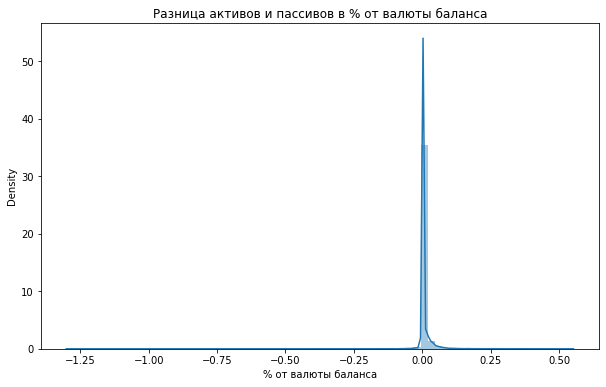

In [51]:
test_bs = pd.pivot_table(grouped_bs_old,
                         index=["DT", "REGN"],
                         values=["IITG","IITG_positive"],
                         aggfunc=np.sum)

print(f"Grouped BS_old:")
test_bs["Discrepancy_relative"] = test_bs.IITG/test_bs.IITG_positive
print(f"Average error relative to size of assets is {test_bs.Discrepancy_relative.mean().round(3)}")
print(f"Average error relative to size of assets in absolute terms is \
{test_bs.Discrepancy_relative.abs().mean().round(3)}")

test_bs["Discrepancy_absolute"] = test_bs.IITG
print(f"Average absolute error {test_bs.Discrepancy_absolute.mean().round()}")
print(f"Average size of assets is {test_bs.IITG_positive.mean().round()}")
print(f"Histogram of relative error size for all observations:")

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(test_bs.Discrepancy_relative, bins = 70, ax=ax)
ax.set_title('Разница активов и пассивов в % от валюты баланса')
ax.set_xlabel('% от валюты баланса')
fig.show();

Number of bank-date observations with zero discrepancy is 0.815
Histogram of relative error size for non-zero observations:


<AxesSubplot:xlabel='Discrepancy_relative', ylabel='Density'>

Text(0.5, 1.0, 'Среднее несхождение баланса в % для банков, где баланс не бьется')

Text(0.5, 0, '% от валюты баланса')

For such observations it is on average equal to 0.016 with sd of 0.043
For such observations it is in absolute terms equal to 0.0 with sd of 0.0


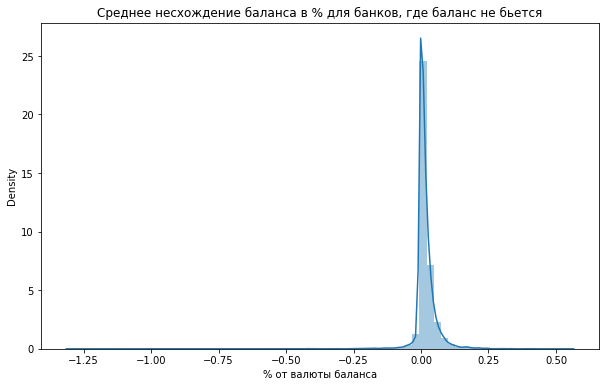

In [61]:
print(f"Number of bank-date observations with zero discrepancy is \
{((test_bs.IITG == 0).sum()/(test_bs.IITG == test_bs.IITG).sum()).round(3)}")
print(f"Histogram of relative error size for non-zero observations:")

mask = (test_bs.Discrepancy_relative != 0)

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(test_bs.Discrepancy_relative[mask], bins=70, ax=ax)
ax.set_title('Среднее несхождение баланса в % для банков, где баланс не бьется')
ax.set_xlabel('% от валюты баланса')
fig.show();

print(f"For such observations it is on average equal to \
{test_bs.Discrepancy_relative[mask].mean().round(3)} \
with sd of {test_bs.Discrepancy_relative[mask].std().round(3)}")

print(f"For such observations it is in absolute terms equal to \
{test_bs.Discrepancy_relative[mask].abs().mean().round()} with sd of \
{test_bs.Discrepancy_relative[mask].abs().std().round()}")

Histogram of relative error size for observations with relative error greater than 5% of assets in absolute terms:


<AxesSubplot:xlabel='Discrepancy_relative', ylabel='Density'>

For such observations it is on average equal to 0.057 with sd of 0.113


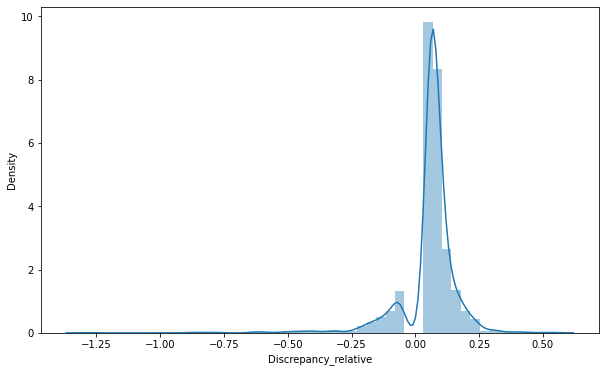

In [57]:
print(f"Histogram of relative error size for observations with relative error greater than 5% of assets in absolute terms:")

mask = (test_bs.Discrepancy_relative > 0.05)|(test_bs.Discrepancy_relative < -0.05)

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(test_bs.Discrepancy_relative[mask], 
         bins = 50, ax=ax)
fig.show();

print(f"For such observations it is on average equal to \
{test_bs.Discrepancy_relative[mask].mean().round(3)} with sd of \
{test_bs.Discrepancy_relative[mask].std().round(3)}")


#### Прочее

In [23]:
all_dicts_assetsliabs = [create_all_dictionaries_for_one_sheet(tree, 1, 1, form) \
                    for tree, form in zip(trees, trees_forms)]
dict_of_dicts_assetsliabs = dict(zip(dict_names, all_dicts_assetsliabs))

In [24]:
%%time
grouped_bs_new_assets_liabilities = group_one_form(bs_new, "BS_new", dict_of_dicts_assetsliabs)
grouped_bs_new_assets_liabilities

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.
Wall time: 11 s


,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2017-07-01,1,Активы,1.240543e+09,125063988.0,1.115479e+09
2017-07-01,1,Собственный капитал,5.915847e+08,763073894.0,-1.714891e+08
2017-08-01,1,Активы,1.196643e+09,122817589.0,1.073825e+09
2017-08-01,1,Собственный капитал,6.818244e+08,856244119.0,-1.744197e+08
2017-09-01,1,Активы,1.186775e+09,123996004.0,1.062779e+09
...,...,...,...,...,...
2021-06-01,3540,Обязательства,0.000000e+00,3829327.0,-3.829327e+06
2021-07-01,3540,Обязательства,0.000000e+00,4605275.0,-4.605275e+06
2021-08-01,3540,Обязательства,0.000000e+00,6497395.0,-6.497395e+06


In [127]:
all_dicts_assetsliabs = [create_all_dictionaries_for_one_sheet(tree, 1, 1, form) \
for tree, form in zip(trees, trees_forms)]

dict_of_dicts_assetsliabs = dict(zip(dict_names, all_dicts_assetsliabs))

grouped_pnl_new_net = group_one_form(pnl_new, "PNL", dict_of_dicts_assetsliabs)
grouped_pnl_new_net



Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2016-04-01,1,Чистая прибыль /(убыток),8.861385e+08,8.947092e+08,-8570727.0
2016-07-01,1,Чистая прибыль /(убыток),1.451986e+09,1.458356e+09,-6370704.0
2016-10-01,1,Чистая прибыль /(убыток),1.812834e+09,1.823860e+09,-11026151.0
2017-01-01,1,Чистая прибыль /(убыток),2.186633e+09,2.204400e+09,-17767292.0
2017-04-01,1,Чистая прибыль /(убыток),2.950108e+08,3.081752e+08,-13164329.0
...,...,...,...,...,...
2021-10-01,3539,Чистая прибыль /(убыток),1.743687e+07,1.864411e+07,-1207244.0
2021-01-01,3540,Чистая прибыль /(убыток),5.512170e+05,8.741180e+05,-322901.0
2021-04-01,3540,Чистая прибыль /(убыток),1.410160e+05,1.674360e+05,-26420.0


Сравним агрегированную прибыль для Альфа-банка и то, что получилось у Марины Александровны.

In [128]:
grouped_pnl_new_net[(grouped_pnl_new_net.REGN == 1326)&(grouped_pnl_new_net.index == "2017-10-01")]

,REGN,new_code,SIM_ITOGO_positive,SIM_ITOGO_negative,IITG
DT,,,,,
2017-10-01,1326,Чистая прибыль /(убыток),2.016773e+09,2.027004e+09,-10230940.0


In [31]:
grouped_bs_new_assets_liabilities = grouped_bs_new_assets_liabilities[["REGN", "new_code", "IITG"]]

## Группировка баланса и ОПУ для получения итогового набора данных.

In [3]:
from preprocessing import create_all_dictionaries_for_one_sheet, group_one_form       

Укажем путь к файлу с деревьями.

In [4]:
path = Path(str(input()))
print(f'Путь, по которому лежит файл Деревья.xlsx: {path}.')

 C://Users//Ivand//Repos//banks//data


Путь, по которому лежит файл Деревья.xlsx: C:\Users\Ivand\Repos\banks\data.


Выгрузим листы с группировками из этого файла, загрузим данные.

In [5]:
trees = [pd.read_excel(path / "Derevya.xlsx", sheet_name = i) \
         for i in range(6)]

trees_forms = ["BS"]*2+["PNL"]*3

#form_101 = pd.read_hdf(path/'101.h5',key='101')
#form_102 = pd.read_hdf(path/'102.h5',key='102')

Получим словарь со всеми словарями для баланса.

In [6]:
%%time
bs_dicts = {}
for bs_level in range(1, 4):
    all_dicts = [create_all_dictionaries_for_one_sheet(tree, 1, bs_level, form) \
                    for tree, form in zip(trees, trees_forms)]
    #save to final dict
    bs_dicts [f"BS_old_{str(bs_level)}"] = all_dicts[0]
    bs_dicts[f"BS_new_{str(bs_level)}"] = all_dicts[1]
    

Wall time: 29.3 s


Получим словарь со словарями для для отчета о прибылях и убытках.

In [7]:
%%time
# is referres to "Income Statement"
is_dicts = {}
for is_level in range(1, 8):
    all_dicts = [create_all_dictionaries_for_one_sheet(tree, is_level, 1, form) \
                    for tree, form in zip(trees, trees_forms)]
    #save to final dict
    is_dicts [f"PNL_very_old_{str(is_level)}"] = all_dicts[2]
    is_dicts[f"PNL_old_{str(is_level)}"] = all_dicts[3]
    is_dicts[f"PNL_{str(is_level)}"] = all_dicts[4]
    

Wall time: 1min 4s


### Получим названия колонок каждого уровня

In [42]:
from preprocessing import create_all_dictionaries_for_one_sheet, group_one_form       
import json

In [ ]:
path = Path(str(input()))
print(f'Путь, по которому лежит файл Деревья.xlsx: {path}.')

In [ ]:
trees = [pd.read_excel(path / "Derevya.xlsx", sheet_name = i) \
         for i in range(6)]

trees_forms = ["BS"]*2+["PNL"]*3

In [36]:
names_dicts_pnl = {}
for is_level in range(1, 8):
    all_dicts = [create_all_dictionaries_for_one_sheet(tree, is_level, 1, form) \
                    for tree, form in zip(trees, trees_forms)]
    print(is_level)
    new_dict = {}
    for i in all_dicts[2]:
        new_dict[list(i.keys())[0]] = list(i.values())[0]
    #save to final dict
    names_dicts_pnl[str(is_level)] = list(new_dict.keys())

    

1
2
3
4
5
6
7


In [39]:
names_dicts_bs = {}
for bs_level in range(1, 4):
    all_dicts = [create_all_dictionaries_for_one_sheet(tree, 1, bs_level, form) \
                    for tree, form in zip(trees, trees_forms)]
    print(bs_level)
    new_dict = {}
    for i in all_dicts[0]:
        new_dict[list(i.keys())[0]] = list(i.values())[0]
    #save to final dict
    names_dicts_bs[str(bs_level)] = list(new_dict.keys())

    

1
2
3


In [43]:
with open('names_levels_pnl.json', 'w', encoding="utf-8") as f:
    json.dump(names_dicts_pnl, f, indent=4, ensure_ascii=False)

In [44]:
with open('names_levels_bs.json', 'w', encoding="utf-8") as f:
    json.dump(names_dicts_bs, f, indent=4, ensure_ascii=False)

### Группировка по схеме ЦБ

In [1]:
import re
import json

In [2]:
from preprocessing import group_one_form                          

In [3]:
import preprocessing

In [6]:
path_str = input()
data = pd.read_csv(path_str + "//BanksDF.csv")

 C:\\Users\\Ivand\\Repos\\banks\\data\\


In [7]:
form_101 = pd.read_hdf(path_str + '//101.h5',key='101')
form_102 = pd.read_hdf(path_str + '//102.h5',key='102')
form_101.NUM_SC = form_101.NUM_SC.apply(str)

cbr_grouping = pd.read_excel(path_str + "//Grouping_CBR.xlsx")

In [15]:
form_101[(form_101.REGN == 1)&(form_101.NUM_SC == "70701")]

,REGN,PLAN,NUM_SC,A_P,VR,VV,VITG,ORA,OVA,OITGA,ORP,OVP,OITGP,IR,IV,IITG,PRIZ
DT,,,,,,,,,,,,,,,,,
2009-02-01,1,А,70701,2,0.0,0.0,0.0,8894.0,0.0,8894.0,125175053.0,0.0,125175053.0,125166159.0,0.0,125166159.0,1
2009-03-01,1,А,70701,2,125166159.0,0.0,125166159.0,125166248.0,0.0,125166248.0,89.0,0.0,89.0,0.0,0.0,0.0,1
2010-02-01,1,А,70701,2,0.0,0.0,0.0,14264.0,0.0,14264.0,194772081.0,0.0,194772081.0,194757817.0,0.0,194757817.0,1
2010-03-01,1,А,70701,2,194757817.0,0.0,194757817.0,194757817.0,0.0,194757817.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-02-01,1,А,70701,2,0.0,0.0,0.0,2756.0,0.0,2756.0,156893615.0,0.0,156893615.0,156890859.0,0.0,156890859.0,1
2011-03-01,1,А,70701,2,156890859.0,0.0,156890859.0,156890859.0,0.0,156890859.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2012-02-01,1,А,70701,2,0.0,0.0,0.0,27052.0,0.0,27052.0,175018417.0,0.0,175018417.0,174991365.0,0.0,174991365.0,1
2012-03-01,1,А,70701,2,174991365.0,0.0,174991365.0,174991365.0,0.0,174991365.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-02-01,1,А,70701,2,0.0,0.0,0.0,2505.0,0.0,2505.0,146588395.0,0.0,146588395.0,146585890.0,0.0,146585890.0,1


In [8]:
def sort_one_string_cbr(string):
    if re.findall("\-", string):
        return "P"
    else:
        return "A"
    
def set_raw_strings_cbr(big_string):
    return pd.Series(re.findall("[\S\+\-]\d+", str(big_string)))

def sort_strings_cbr(strings):
    return strings.apply(sort_one_string_cbr)

def findall_redefined(string, pattern):
    return re.findall(pattern, string)[0]

def uncover_strings_cbr(strings):
    return strings.apply(findall_redefined, pattern = "\d+")

def strings_and_sorts(big_string):
    strings = set_raw_strings_cbr(big_string)
    strings_sorts = sort_strings_cbr(strings)
    strings_uncovered = uncover_strings_cbr(strings)
    return pd.DataFrame({"code" : strings_uncovered, "type" : strings_sorts})

@np.vectorize
def convert_string_to_dictionary(string, string_name):
    df = strings_and_sorts(string)
    df_assets = list(df[df.type == "A"].code)
    df_liabilities = list(df[df.type == "P"].code)
    return {string_name : {"A" : df_assets, "P" : df_liabilities}}

def get_cbr_dictionaries(grouping_cbr):
    thedict = list(convert_string_to_dictionary(grouping_cbr[grouping_cbr.columns[1]], grouping_cbr[grouping_cbr.columns[0]]) )
    return  {"BS_new" : thedict, "BS_old" : thedict}

cbr_grouping_dict = get_cbr_dictionaries(cbr_grouping)

In [ ]:
cbr_grouping_dict

In [9]:
cbr_aggregated_low = group_one_form(form_101, "BS_old", cbr_grouping_dict)

Grouping and aggregating data. Please be patient...
Finished.
Grouping and aggregating data. Please be patient...
Finished.


In [10]:
m = cbr_aggregated_low[cbr_aggregated_low.REGN == 1]
m[m.new_code == "Прибыль (убыток) прошлых лет"]

,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2008-02-01,1,Прибыль (убыток) прошлых лет,594739.0,0.0,594739.0
2008-03-01,1,Прибыль (убыток) прошлых лет,594739.0,0.0,594739.0
2008-04-01,1,Прибыль (убыток) прошлых лет,15731352.0,0.0,15731352.0
2008-05-01,1,Прибыль (убыток) прошлых лет,15731352.0,0.0,15731352.0
2008-06-01,1,Прибыль (убыток) прошлых лет,15731352.0,0.0,15731352.0
...,...,...,...,...,...
2021-06-01,1,Прибыль (убыток) прошлых лет,143704901.0,0.0,143704901.0
2021-07-01,1,Прибыль (убыток) прошлых лет,143704901.0,0.0,143704901.0
2021-08-01,1,Прибыль (убыток) прошлых лет,143704901.0,0.0,143704901.0


In [13]:
m

,REGN,new_code,IITG_positive,IITG_negative,IITG
DT,,,,,
2007-01-01,1,Cредства клиентов в расчетах,676569.0,0.0,676569.0
2007-01-01,1,Векселя и банковские акцепты,266598.0,0.0,266598.0
2007-01-01,1,Государственные структуры,577396.0,0.0,577396.0
2007-01-01,1,Дебиторы,1012197.0,0.0,1012197.0
2007-01-01,1,"Денежные средства (касса, чеки, денежные средс...",5173811.0,0.0,5173811.0
...,...,...,...,...,...
2021-06-01,1,Долговые ценные бумаги,0.0,10610.0,-10610.0
2021-07-01,1,Долговые ценные бумаги,0.0,8466.0,-8466.0
2021-08-01,1,Долговые ценные бумаги,0.0,15.0,-15.0


In [40]:
cbr_aggregated_low = cbr_aggregated_low[["REGN", "new_code", "IITG"]]
cbr_aggregated_low = cbr_aggregated_low.pivot_table(index = ["DT", "REGN"], columns = ["new_code"], values = ["REGN", "IITG"])
cbr_names = list(cbr_aggregated_low.columns.droplevel(0))
cbr_names = cbr_names[2:]
cbr_aggregated_low = cbr_aggregated_low.reset_index()
cbr_aggregated_low.columns = ["DT", "REGN"] + cbr_names
cbr_aggregated_low.to_excel(f"{path}//BS_CBR_aggregated.xlsx")

In [66]:
cbr_aggregated_low.to_excel(f"{path}//BS_CBR_aggregated.xlsx")

In [65]:
cbr_aggregated_low

,DT,REGN,Cредства клиентов в расчетах,Безвозмездное финансирование,Векселя (с учетом переоценки и корректировки стоимости),Векселя и банковские акцепты,Вложения в ценные бумаги Банка России,Государственные структуры,Дебиторы,"Денежные средства (касса, чеки, денежные средства в пути, в банкоматах)",...,Средства на счетах,Счета эскроу физических лиц по договорам участия в долевом строительстве,Требования по начисленным процентам (без учета начисленных процентов (купонов) по ценным бумагам),Уставный капитал кредитных организаций,"Участие в уставных капиталах дочерних и зависимых акционерных обществах, паевых инвестиционных фондах",Физические лица,Финансовая аренда (лизинг),Финансовые организации,Чистая прибыль текущего года,Эмисcионный доход
0,2007-01-01,1,676569.0,NaN,NaN,266598.0,NaN,577396.0,1012197.0,5173811.0,...,8206024.0,NaN,515740.0,NaN,114.0,22332830.0,NaN,60201.0,NaN,7837.0
1,2007-01-01,3,1.0,NaN,NaN,259560.0,NaN,NaN,416.0,13728.0,...,43775.0,NaN,122.0,NaN,NaN,111745.0,NaN,NaN,NaN,60353.0
2,2007-01-01,21,482.0,NaN,NaN,632.0,NaN,NaN,6093.0,40060.0,...,5299.0,NaN,NaN,NaN,NaN,61729.0,NaN,NaN,NaN,NaN
3,2007-01-01,52,6664.0,NaN,NaN,55356.0,NaN,NaN,1515.0,70596.0,...,24403.0,NaN,1647.0,NaN,NaN,348887.0,NaN,7679.0,NaN,75576.0
4,2007-01-01,55,5.0,NaN,NaN,236030.0,NaN,NaN,1116.0,163524.0,...,37453.0,NaN,96.0,NaN,0.0,271423.0,NaN,0.0,NaN,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125735,2021-10-01,3533,5701.0,180660.0,NaN,NaN,NaN,NaN,1288.0,3636.0,...,NaN,NaN,0.0,90000.0,NaN,NaN,4001.0,NaN,-47594.0,NaN
125736,2021-10-01,3536,NaN,233383.0,NaN,NaN,NaN,NaN,1030.0,47633.0,...,NaN,NaN,164.0,90000.0,NaN,NaN,2803.0,NaN,-16441.0,NaN
125737,2021-10-01,3538,NaN,91041.0,NaN,NaN,NaN,NaN,1471.0,NaN,...,NaN,NaN,310.0,340000.0,NaN,NaN,1108.0,NaN,51073.0,NaN
125738,2021-10-01,3539,NaN,NaN,NaN,NaN,NaN,NaN,6040.0,NaN,...,NaN,NaN,0.0,702495.0,NaN,NaN,7893.0,48.0,1207244.0,NaN


In [69]:
with open(path_str + '\\names_levels_bs_cbr.json', 'w', encoding="utf-8") as f:
    json.dump(cbr_names, f, indent=4, ensure_ascii=False)

In [33]:
cbr_aggregated_low.to_hdf(path_str + "//DataBanksBSCBRLow.h5", key = "CBR")